In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Structure of this notebook:
1. Import preprocessed data (exported at the end of EDA)
2. Select features, train-test-split
3. Modeling
    - Logistic Regression (98% prediction accuracy on test set)
        - Train model
        - Model performance on test set
        - Feature importance
    - Random Forest (99% prediction accuracy on test set)
        - Train model
        - Model performance on test set
        - Feature importance

## Import processed data

In [2]:
merged = pd.read_csv("merged.csv", index_col=0)
merged_dummy = pd.read_csv("merged_dummy.csv", index_col=0)

__merged_dummy is the one used for modeling!__ See Feature Engineering section at the end of my EDA notebook for details

In [3]:
merged.shape, merged_dummy.shape

((167880, 51), (167880, 63))

## Feature selection and train-test-split

In [4]:
merged.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'track_id', 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector

#### feature selection

In [5]:
# include all numerical, bool, and "useful" multicategorical variables ("useful" is based on EDA)
columns_to_drop = ['session_id', 'track_id_clean', 'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'track_id', 'date',  'context_type', 'mode']
X = merged_dummy.drop(columns_to_drop, axis=1)
y = merged_dummy['not_skipped']

#### train-test-split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((117516, 53), (50364, 53), (117516,), (50364,))

## Modeling

### Logistic Regression

#### Train model

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# this is a bit slow
m = LogisticRegression(max_iter = 4000)
m.fit(X_train, y_train)

# prediction accuracy on test set
m.score(X_test, y_test)

0.9865181478834087

#### Model performance metrics

In [11]:
# Predicted y for X_test
y_test_pred = m.predict(X_test)

In [12]:
# Precision
# Among those predicted not skipped, what proportion are truly not skipped?

from sklearn.metrics import precision_score

# True labels (ground truth)
true_labels = y_test

# Predicted labels
predicted_labels = y_test_pred

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
precision

0.9681144129886876

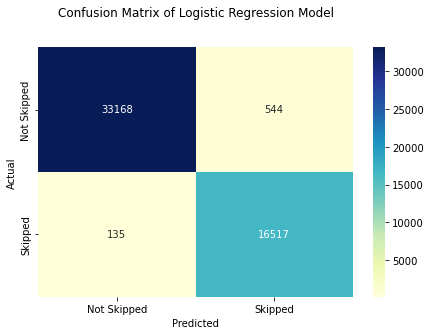

In [19]:
from sklearn.metrics import confusion_matrix

class_names=["Not Skipped", "Skipped"]
fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred)), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion Matrix of Logistic Regression Model', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

plt.savefig("confusion_matrix_logistic.png", dpi=300, bbox_inches='tight')

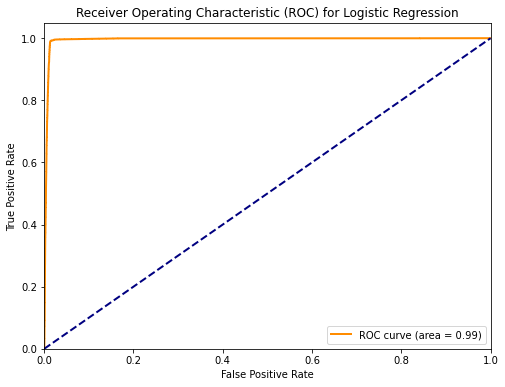

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC curve
y_score = m.predict_proba(X_test)[:, 1]  # Probability of class 1
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Logistic Regression')
plt.legend(loc='lower right')
plt.savefig("ROC_logistic.png", dpi=300)
plt.show()

#### Feature importance

In [21]:
coefficients = m.coef_[0]

# Create a DataFrame to associate coefficients with feature names
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute values of coefficients to see the most important features
coef_df['Absolute Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False)
sorted_coef_df["Importance"] = range(1, len(sorted_coef_df)+ 1)

In [23]:
sorted_coef_df[['Importance', 'Feature', 'Coefficient', 'Absolute Coefficient']].head()

,Importance,Feature,Coefficient,Absolute Coefficient
52,1,hist_user_behavior_reason_end_trackdone,9.904501,9.904501
6,2,hist_user_behavior_n_seekfwd,-3.067283,3.067283
48,3,hist_user_behavior_reason_end_endplay,2.059239,2.059239
7,4,hist_user_behavior_n_seekback,1.973410,1.973410
45,5,hist_user_behavior_reason_start_trackdone,1.957574,1.957574


Behaviors about users that indicate not skipped:
- Track is ended because: trackdone, endplay
- Track is started because: trackdone, clickrow, fwdbtn, backbtn
- Less seeking forward behaviors
- More seeking back behaviors

Important features of not skipped songs are: 
- Higher acousticness (acousticness is a confidence measure from 0.0 to 1.0 of whether the track is acoustic)
- Higher speechiness: presence of spoken words
- Lower danceability: less danceable <br>

See how to interpret these features [here](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features)


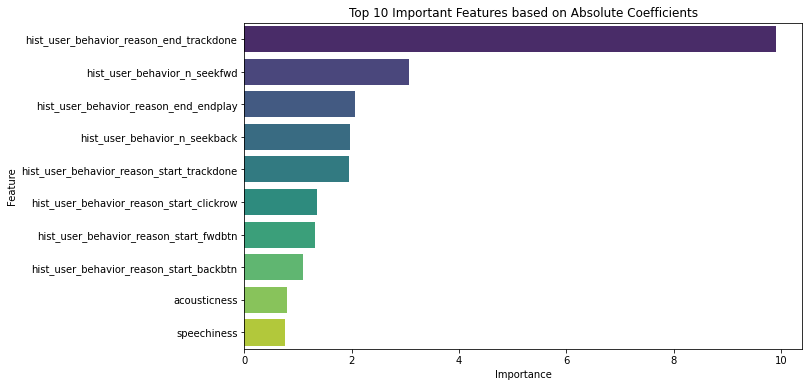

In [34]:
top_10_features = sorted_coef_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Absolute Coefficient', y='Feature', data=top_10_features, palette='viridis')
plt.title('Top 10 Important Features based on Absolute Coefficients')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig("Top_10_features_Logistic", dpi=300, bbox_inches='tight')
plt.show()

### Random forest

#### Train model

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)
rf.score(X_test, y_test) # ~98.98% of predictions for test set are correct

0.9897744420617902

#### Model preformance metrics

In [30]:
# Predicted y for X_test
y_test_pred_rf = rf.predict(X_test)

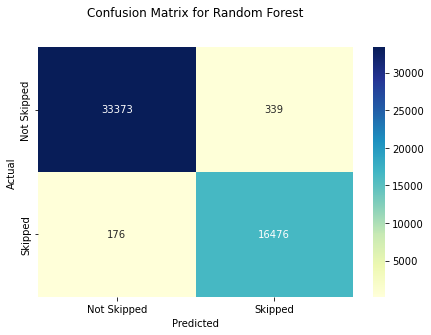

In [32]:
from sklearn.metrics import confusion_matrix

# confusion matrix for RF model
class_names=["Not Skipped", "Skipped"]
fig, ax = plt.subplots()

sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_test_pred_rf)), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion Matrix for Random Forest', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.savefig("confusion_matrix_random_forest.png", dpi=300, bbox_inches='tight')

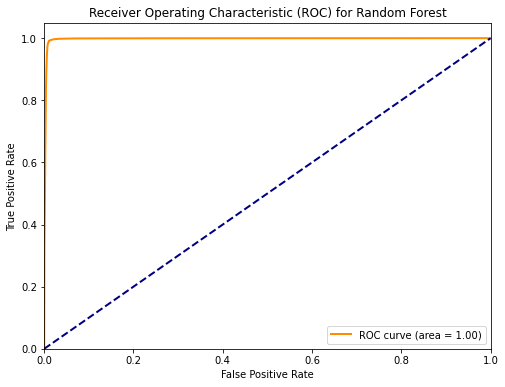

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC curve for RF model
y_score = rf.predict_proba(X_test)[:, 1]  # Probability of class 1
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Random Forest')
plt.legend(loc='lower right')
plt.savefig("ROC_RF.png", dpi=300)
plt.show()

#### Feature Importance

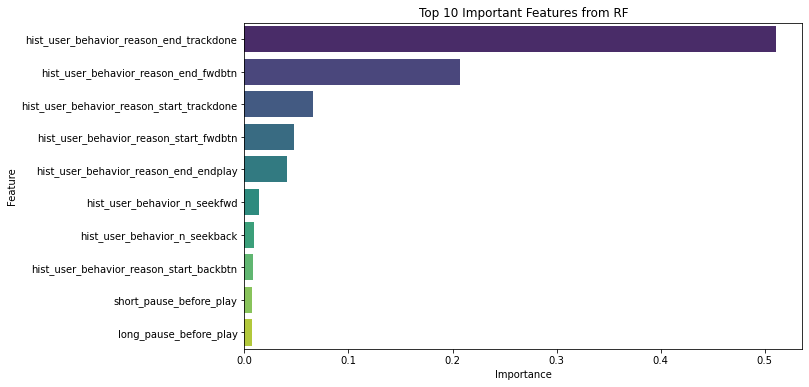

In [40]:
# Get feature importance scores and feature names
feature_importance = rf.feature_importances_
feature_names = X.columns  

# Sort feature importance in descending order
sorted_idx = feature_importance.argsort()[::-1]

# Select the top N most important features to display (e.g., top 10)
top_n = 10
sorted_feature_names = [feature_names[i] for i in sorted_idx[:top_n]]
sorted_feature_importance = feature_importance[sorted_idx[:top_n]]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importance, y=sorted_feature_names, palette='viridis')
plt.title('Top 10 Important Features from RF')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig("Top_10_features_RF", dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# Create a DataFrame to associate coefficients with feature names
coef_df1 = pd.DataFrame({'Feature': X.columns, 'Importance Score': feature_importance})

# Sort the DataFrame by the absolute values of coefficients to see the most important features
sorted_coef_df1 = coef_df1.sort_values(by='Importance Score', ascending=False)
sorted_coef_df1["Importance"] = range(1, len(sorted_coef_df1) + 1)

In [43]:
sorted_coef_df1[["Importance", "Feature", "Importance Score"]].head()

,Importance,Feature,Importance Score
52,1,hist_user_behavior_reason_end_trackdone,0.510835
49,2,hist_user_behavior_reason_end_fwdbtn,0.207337
45,3,hist_user_behavior_reason_start_trackdone,0.065626
42,4,hist_user_behavior_reason_start_fwdbtn,0.047957
48,5,hist_user_behavior_reason_end_endplay,0.040508


In [ ]:
# what if we use the same logistic reg model but exclude all categorical variables from X?

In [44]:
columns_to_drop1 = ['session_id', 'track_id_clean', 'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'track_id', 'date',  'context_type', 'mode', 
                   "hist_user_behavior_reason_start", "hist_user_behavior_reason_end"]
X1 = merged.drop(columns_to_drop1, axis=1)
y1 = merged['not_skipped']

In [45]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3)
X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape
# much fewer features (39 vs. 53)

((117516, 39), (50364, 39), (117516,), (50364,))

In [46]:
m1 = LogisticRegression(max_iter = 2000)
m1.fit(X1_train, y1_train)
m1.score(X1_test, y1_test)
# bad prediction accuracy: only ~66%

0.664164879675959